In [65]:
!pip install category_encoders

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [67]:
def wrangle(crime):

  crime = pd.read_csv('crime.csv', parse_dates={'DATE' : ['YEAR', 'MONTH', 'DAY_OF_WEEK']},
  index_col='DATE').sort_values(by='DATE')

  # Drop all rows that have a NaN values in DISTRICT'
  crime = crime.dropna(axis=0, subset=['DISTRICT'])

  crime = crime.fillna(0)
  crime['SHOOTING'].replace('Y','1', inplace=True)
  crime['SHOOTING'].astype('int')
  
  # Drop columns with high cardinality and complex strings
  crime.drop('INCIDENT_NUMBER', axis=1, inplace=True)
  crime.drop('OFFENSE_CODE_GROUP', axis=1, inplace=True)
  crime.drop('OFFENSE_DESCRIPTION', axis=1, inplace=True)
  
  # Reduce rows based on the frequency an Offense happens
  crime = crime[crime['OFFENSE_CODE'].isin(['3006', '3115', '3831', '1402', '802'
  '3301', '3410', '3114', '2647', '617', '3201', '614', '3125', '613', '3802', '619', '3803'
  '413', '1102', '3502'])]

  return crime

crime = wrangle('crime')

C:\Users\akeps\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [68]:
# Verify that data is in ascending order

crime.head()

,OFFENSE_CODE,DISTRICT,REPORTING_AREA,SHOOTING,HOUR
DATE,,,,,
2015-06-01,3125,D4,903,0,0
2015-06-01,613,D4,134,0,18
2015-06-01,614,A15,37,0,17
2015-06-01,3201,B3,465,0,18
2015-06-01,3831,A1,105,0,18


In [69]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168755 entries, 2015-06-01 to 2018-10-03
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   OFFENSE_CODE    168755 non-null  int64 
 1   DISTRICT        168755 non-null  object
 2   REPORTING_AREA  168755 non-null  object
 3   SHOOTING        168755 non-null  object
 4   HOUR            168755 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.7+ MB


In [70]:
# Tested filtering of OFFENSE_CODE here an moved to Wrangle function

# crime_OC = crime[crime['OFFENSE_CODE'].isin(['3006', '3115', '3831', '1402', '802'
# '3301', '3410', '3114', '2647', '617'])]

In [71]:
# Looking at the likelihood DISTRICT is a predictor of higher crime areas

crime.groupby('DISTRICT')['SHOOTING'].value_counts()

DISTRICT  SHOOTING
A1        0           19778
          1               2
A15       0            3649
          1               1
A7        0            6806
          1               2
B2        0           24180
          1              48
B3        0           17111
          1              28
C11       0           22013
          1              20
C6        0           13120
          1               4
D14       0           11634
          1               6
D4        0           24366
          1               7
E13       0            9299
          1              10
E18       0            9621
          1               4
E5        0            7045
          1               1
Name: SHOOTING, dtype: int64

In [72]:
# Choose target so that we can predict with what % of crimes, shootings occur
# Why does REPORTING_AREA not work as the target?

target = 'DISTRICT'
y = crime[target]
X = crime.drop(target, axis=1)

In [73]:
y.head()

DATE
2015-06-01     D4
2015-06-01     D4
2015-06-01    A15
2015-06-01     B3
2015-06-01     A1
Name: DISTRICT, dtype: object

In [74]:
# Split the data according to date with incidents in 2018 being used as test data

cutoff = '2018-01-01'
train_mask = X.index < cutoff
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[~train_mask], y.loc[~train_mask]

In [75]:
print('Baseline accuracy:', y_train.value_counts(normalize=True))

Baseline accuracy: D4     0.144982
B2     0.144866
C11    0.130833
A1     0.117454
B3     0.100545
C6     0.076532
D14    0.068719
E18    0.056124
E13    0.054786
E5     0.042230
A7     0.040646
A15    0.022284
Name: DISTRICT, dtype: float64


In [76]:
# Linear Model

model_lr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(random_state= 42, n_jobs= -1)
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['REPORTING_AREA', 'SHOOTING'],
                                mapping=[{'col': 'REPORTING_AREA',
                                          'data_type': dtype('O'),
                                          'mapping': 903      1
134      2
37       3
465      4
105      5
      ... 
958    874
669    875
386    876
190    877
NaN     -2
Length: 878, dtype: int64},
                                         {'col': 'SHOOTING',
                                          'data_type': dtype('O'),
                                          'mapping': 0      1
1      2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=42))])

In [77]:
y_lr_train_pred = model_lr.predict(X_train)
y_lr_test_pred = model_lr.predict(X_test)

In [78]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

accuracy_score(y_train, y_lr_train_pred)

# Below will not compute for DISTRICT data type. Left it here because it works
# with other targets.

# lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
# lr_train_r2 = r2_score(y_train, y_lr_train_pred)
# lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
# lr_test_r2 = r2_score(y_test, y_lr_test_pred)


0.18182866721516944

In [79]:
# Also works with other Targets

# crime_lr_results = pd.DataFrame(['Linear Regression', lr_train_mse,
# lr_train_r2, lr_test_mse, lr_test_r2]).transpose()

# crime_lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

# crime_lr_results

In [80]:
# Tree Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(max_depth= 10, random_state=42, n_jobs=-1)
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['REPORTING_AREA', 'SHOOTING'],
                                mapping=[{'col': 'REPORTING_AREA',
                                          'data_type': dtype('O'),
                                          'mapping': 903      1
134      2
37       3
465      4
105      5
      ... 
958    874
669    875
386    876
190    877
NaN     -2
Length: 878, dtype: int64},
                                         {'col': 'SHOOTING',
                                          'data_type': dtype('O'),
                                          'mapping': 0      1
1      2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_jobs=-1,
                                        random_state=42))])

In [81]:
y_rf_train_pred = model_rf.predict(X_train)
y_rf_test_pred = model_rf.predict(X_test)

In [82]:
accuracy_score(y_train, y_rf_train_pred)

0.40227295445632866

In [83]:
# Works for Targets that are integer data types

# rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
# rf_train_r2 = r2_score(y_train, y_rf_train_pred)
# rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
# rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [84]:
# Works for Targets that are integer data types

# crime_rf_results = pd.DataFrame(['Random Forest', lr_train_mse,
# rf_train_r2, rf_test_mse, rf_test_r2]).transpose()

# crime_rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

# crime_rf_results

In [85]:
!pip install xgboost

In [86]:
# Boosting model
from xgboost import XGBClassifier

model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42)
)

model_boost.fit(X_train, y_train)

C:\Users\akeps\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['REPORTING_AREA', 'SHOOTING'],
                                mapping=[{'col': 'REPORTING_AREA',
                                          'data_type': dtype('O'),
                                          'mapping': 903      1
134      2
37       3
465      4
105      5
      ... 
958    874
669    875
386    876
190    877
NaN     -2
Length: 878, dtype: int64},
                                         {'col': 'SHOOTING',
                                          'data_type': dtype('O'),
                                          'mapping': 0      1
1      2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_wei

In [87]:
y_boost_train_pred = model_boost.predict(X_train)
y_boost_test_pred = model_boost.predict(X_test)

In [88]:
accuracy_score(y_train, y_boost_train_pred)

0.9441296106911904

In [89]:
# Works for Targets that are integer data types

# crime_boost_train_mse = mean_squared_error(y_train, y_crime_boost_train_pred)
# crime_boost_train_r2 = r2_score(y_train, y_crime_boost_train_pred)
# crime_boost_test_mse = mean_squared_error(y_test, y_crime_boost_test_pred)
# crime_boost_test_r2 = r2_score(y_test, y_crime_boost_test_pred)

In [90]:
# Works for Targets that are integer data types

# crime_boost_results = pd.DataFrame(['Random Forest', crime_boost_train_mse,
# crime_boost_train_r2, crime_boost_test_mse, crime_boost_test_r2]).transpose()

# crime_boost_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

# crime_boost_results

In [91]:
print('Linear Model')
print('Training accuracy:', model_lr.score(X_train, y_train))
print('Testing accuracy:', model_lr.score(X_test, y_test))
print()
print('Bagging Model')
print('Training accuracy:', model_rf.score(X_train, y_train))
print('Testing accuracy:', model_rf.score(X_test, y_test))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Testing accuracy:', model_boost.score(X_test, y_test))

Linear Model
Training accuracy: 0.18182866721516944
Testing accuracy: 0.17481397271599836

Bagging Model
Training accuracy: 0.40227295445632866
Testing accuracy: 0.38512815212897894

Boosting Model
Training accuracy: 0.9441296106911904
Testing accuracy: 0.9418406366267053


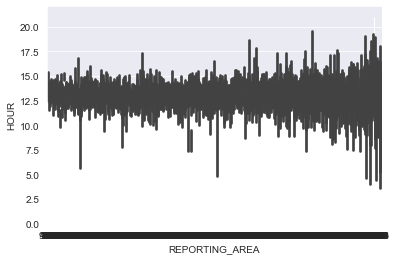

In [64]:
import seaborn as sns
sns.set_style('darkgrid')
sns.barplot(x= 'REPORTING_AREA', y= 'HOUR', data= crime)
plt.show()

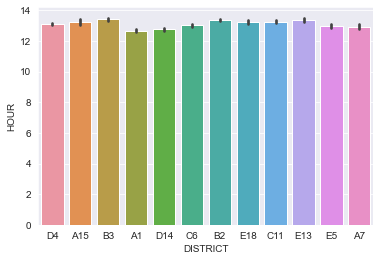

In [61]:
import seaborn as sns

sns.set_style('darkgrid')

sns.barplot(x= 'DISTRICT', y= 'HOUR', data= crime)
plt.show()

In [34]:
# PDP box does not install for some reason, still researching

# !pip install pdpbox

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['DISTRICT', 'HOUR']

interact = pdp_interact(
    model=model_rf,
    dataset=X_test.dropna(),
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);
